In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pysubgroup as ps

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [17]:
np.random.seed(100)
data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
data_shuffle = data.copy()
data_shuffle['age'] = np.random.permutation(data_shuffle['age'].values)
data_shuffle.head()

cate_features = ['education', 'occupation', 'marital-status', 'race', 'sex']
num_features = ['age', 'hours-per-week']
target = 'target'
data_cate = data[cate_features]
data_num = data[num_features]
shuffle_num = data_shuffle[num_features]

X = pd.get_dummies(data_cate, drop_first=True).join(data_num, how='inner')
shuffle_X = pd.get_dummies(data_cate, drop_first=True).join(shuffle_num, how='inner')
y = data[target]

rf_model = RandomForestClassifier(random_state=0).fit(X, y)

prob = np.amax(rf_model.predict_proba(X), axis=1)
shuff_prob = np.amax(rf_model.predict_proba(shuffle_X), axis=1)
avg_effect = np.mean(shuff_prob) - np.mean(prob)

data_shuffle['age_change'] = data_shuffle['age'] - data['age']
data_shuffle['deviation'] = (shuff_prob - prob) - avg_effect
data_shuffle.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_change,deviation
0,27,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,-12,0.021068
1,24,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,-26,0.421068
2,30,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,-8,0.021068
3,20,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,-33,-0.078932
4,54,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,26,-0.078932


In [18]:
grouped_data = data_shuffle.groupby(data_shuffle['age_change'])
df_age = grouped_data[['deviation']].mean()
df_effect = pd.DataFrame(df_age.index)
df_effect['mean_effect'] = df_age['deviation'].values
pear_corr = np.corrcoef(df_effect['age_change'].values, df_effect['mean_effect'].values)[0, 1]
print('pearson correlation: ', pear_corr)
df_effect.head()

pearson correlation:  -0.5844541439755132


,age_change,mean_effect
0,-71,0.121068
1,-67,0.081371
2,-66,0.021068
3,-65,0.026624
4,-64,0.054401


Text(10,0.1,'pearson correlation: -0.58')

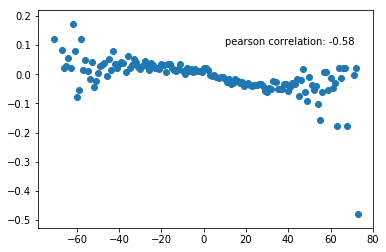

In [19]:
fig, ax = plt.subplots()
ax.scatter(df_effect['age_change'], df_effect['mean_effect'])
ax.annotate('pearson correlation: {0}'.format(round(pear_corr, 2)), (10, 0.1))

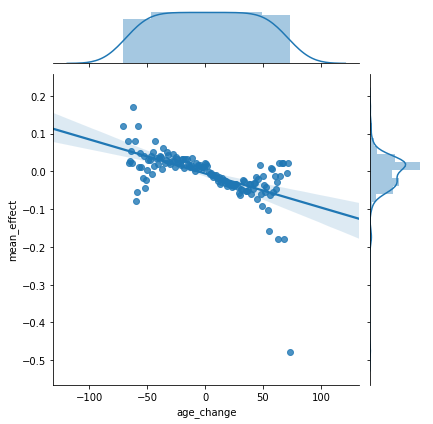

In [20]:
sns.jointplot(x=df_effect['age_change'], y=df_effect['mean_effect'], data=df_effect, kind="reg")

In [21]:
data_shuffle.head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,age_change,deviation
0,27,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,-12,0.021068
1,24,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,-26,0.421068
2,30,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,-8,0.021068
3,20,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,-33,-0.078932
4,54,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,26,-0.078932


In [22]:
target = ps.NumericTarget('deviation')
search_space = ps.create_numeric_selectors(data_shuffle, ignore=['age', 'target', 'deviation'])
task = ps.SubgroupDiscoveryTask(data_shuffle, target, search_space, qf=ps.StandardQF_numeric(1))
result = ps.BeamSearch().execute(task)
ps.as_df(data_shuffle, result, statistics_to_show=ps.all_statistics_numeric)

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,292.018761,hours-per-week: [40:41[,15217.0,32561.0,0.019190,3.660282e-17,0.170454,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,5.242847e+14,1.0
1,278.316409,capital-loss: [0:155[ AND hours-per-week: [40:41[,14559.0,32561.0,0.019116,3.660282e-17,0.169278,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,5.222672e+14,1.0
2,247.748016,hours-per-week: [40:41[ AND capital-gain: [0:114[,14096.0,32561.0,0.017576,3.660282e-17,0.167694,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,4.801752e+14,1.0
3,234.045665,hours-per-week: [40:41[ AND capital-gain: [0:1...,13438.0,32561.0,0.017417,3.660282e-17,0.166260,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,4.758296e+14,1.0
4,192.696477,hours-per-week: [40:41[ AND age_change<-16,2938.0,32561.0,0.065588,3.660282e-17,0.192839,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,1.791874e+15,1.0
5,191.898619,capital-loss: [0:155[ AND age_change<-16,6099.0,32561.0,0.031464,3.660282e-17,0.191463,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,8.596045e+14,1.0
6,187.951275,capital-loss: [0:155[ AND age_change<-16 AND h...,2781.0,32561.0,0.067584,3.660282e-17,0.191884,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,1.846417e+15,1.0
7,185.712097,education-num: [9:10[,10501.0,32561.0,0.017685,3.660282e-17,0.164771,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,4.831645e+14,1.0
8,183.448194,age_change<-16,6451.0,32561.0,0.028437,3.660282e-17,0.193270,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,7.769120e+14,1.0
9,183.051619,hours-per-week: [40:41[ AND education-num: [9:10[,5524.0,32561.0,0.033138,3.660282e-17,0.167076,0.167874,0.021068,0.021068,0.521068,0.521068,-0.478932,-0.478932,9.053268e+14,1.0
